# Profitable Movies: 
## Budget, ROI, and Key Features

### Project Overview
This analysis of movie data, sourced from Kaggle, The Numbers, and IMDb, investigates the financial success of movies by analyzing the risk-reward relationship between production budget and profitability, adjusted to the yearly Consumer Price Index. This analysis leverages historical movie data to identify patterns and key features, such as genres, directors, and number of principals, that correlate with higher profitability. By applying statistical techniques like ANOVA and linear regression, the project uncovers which genres and budget categories lead to the most successful movies. Additionally, the project offers recommendations for future movie production, focusing on maximizing ROI based on these identified success factors.

### Business Problem
The movie industry operates in a highly competitive environment where production companies aim to maximize profitability while minimizing financial risk. However, predicting the financial success of a movie is challenging due to various factors like genre, budget, cast, and market trends. This project seeks to address this uncertainty by identifying the key features that drive higher returns on investment (ROI) for movies. The goal is to provide movie studios and producers with actionable insights to optimize their budgets and make informed decisions about which genres, directors, and budget levels are more likely to result in profitable outcomes. By analyzing historical data, the project can help studios focus their resources on the most promising projects, thereby improving financial performance in an unpredictable market.

### Data Understanding

The project uses movie data sourced from Kaggle, The Numbers, and IMDb and historical Consumer Price Index tables from the US Bureau of Labor Statistics. Key data fields include genres, adjusted production budgets, adjusted domestic and worldwide gross earnings, and directors’ information. The focus is on maximizing inflation-adjusted ROI to evaluate the financial success of movies, while accounting for risk as determined by production budget.

Key insights from the data include:

Genres like Horror, Family, and Comedy often deliver high ROI, especially for low-budget movies.
Directors with strong track records in specific genres tend to have higher ROI.
Data cleaning involved uniting disparate data sets, adjusting for inflation, handling missing values and normalizing multi-genre entries.
This data provided a strong foundation for further analysis using ANOVA tests and linear regression models to identify key success factors for movies.

#### Source Details

The Kaggle dataset has detailed financial and production information for movies, which is up-to-date and suitable for analysis. 

The Numbers is an online movie database service. The dataset from them is somewhat outdated but reasonably large. It incorporates few features but provides comprehensive budget and gross earnings data.

Consumer Price Index (CPI) Tables sourced from the US Bureau of Labor Statistics are used to adjust financial data for inflation, ensuring all monetary figures are standardized over time.

IMDb SQLite3 database is a rich and comprehensive source of movie features for analysis. However, it lacks financial metrics for evaluating movie success. It is structured as follows:

![ERD showing primary datasets "movie_basics" and "persons" with tables of relationships between movies and persons and some additional movie data tables](movie_data_erd.jpeg)

In [49]:
# Importing several standard modules in our Preparation and Analysis
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [50]:
#Connecting to our IMDB Sqlite database file
con = sqlite3.connect('Data/im.db')

In [51]:
#Use Pandas to quickly validate EDA information
pd.read_sql('''

SELECT *
FROM sqlite_master

''', con)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [52]:
pd.read_sql('''

SELECT *
FROM movie_basics
LIMIT 15
        
''', con)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


### Data Preparation

In our project, data preparation was a key step to ensure accurate analysis.

We addressed missing values, removed duplicates, and ensured data consistency across all relevant fields.
We merged datasets (movies, directors, and others) based on movie_id and person_id to consolidate essential information like gross earnings, genres, and director details.
Handling Multi-Genres: We split multi-genre entries to analyze each genre's impact separately on metrics like ROI.
We normalized ROI by considering production budgets and gross earnings adjusted for inflation. We created new features like approval index and normalized budgets to improve insights.We filtered directors based on relevant criteria such as age and status (alive) for modern analysis.

In [53]:
# Reading in financial data csvs
tn_data = pd.read_csv('Data/tn.movie_budgets.csv')
kaggle_data = pd.read_csv('Data/movie_statistic_dataset.csv')
inflation_data  = pd.read_csv('Data/US_CPI.csv')

# Reading in IMDB movie basics
imdb_data = pd.read_sql('SELECT * FROM movie_basics', con)

# We investigated whether data from Box Office Mojo could fill in missing data from The Numbers, it did not turn out to be relevant.
bom_data = pd.read_csv('Data/bom.movie_gross.csv')

In [ ]:
#Getting tables used for Tableau
pd.read_sql('''
SELECT *
FROM principals
''',con).to_csv('Tableau/imdb_principals.csv')

pd.read_sql('''
SELECT *
FROM persons
''',con).to_csv('Tableau/imdb_persons.csv')

pd.read_sql('''
SELECT *
FROM directors
''',con).to_csv('Tableau/imdb_directors.csv')

pd.read_sql('''
SELECT *
FROM writers
''',con).to_csv('Tableau/imdb_writers.csv')

pd.read_sql('''
SELECT *
FROM movie_ratings
''',con).to_csv('Tableau/imdb_ratings.csv')

df_clean_movies[[
                'movie_id',
                'movie_title',
                'genres_x',
                'year',
                'adjusted_production_budget',
                'adjusted_domestic_gross',
                'adjusted_worldwide_gross',
                'adjusted_ROI',
                'approval_Index'
                ]].to_csv('Tableau/movies.csv')

In [54]:
# Financial data in TN dataset was formatted as a string with $#,###,###
# converts monetary values in the dataset from strings to floats
tn_data['production_budget'] = tn_data['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
tn_data['domestic_gross'] = tn_data['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
tn_data['worldwide_gross'] = tn_data['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)


In [55]:
tn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


In [56]:
# Filtering tn_data by production budget
tn_data = tn_data[tn_data['production_budget'] != 0]

In [57]:
# Merging tn_data with bom_data
tn_and_bom = tn_data.merge(bom_data, left_on='movie', right_on='title', how='left')

In [58]:
# Further filtering tn_and_bom based on domestic_gross values
tn_and_bom = tn_and_bom[(tn_and_bom['domestic_gross_x'] != 0) | (tn_and_bom['domestic_gross_y'].notnull())]

In [59]:
# the bom_data only contains information for 8 movies that are not already in the tn_data. 
# the analysis could stop looking further.
tn_and_bom[tn_and_bom['domestic_gross_x']==0 & (tn_and_bom['domestic_gross_y'].notnull())]

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
2850,51,"Nov 14, 2014",Wolves,18000000.0,0.0,94953.0,Wolves,KE,12100.0,NaN,2014.0
3153,54,"Dec 6, 2013",Khumba,15000000.0,0.0,20898221.0,Khumba,MNE,1000.0,27200000,2013.0
4463,64,"Jun 6, 2014",Anna,4357373.0,0.0,1200000.0,Anna,VE,4300.0,NaN,2014.0
4768,69,"Sep 18, 1967",Point Blank,3000000.0,0.0,0.0,Point Blank,Magn.,708000.0,8500000,2011.0
4865,66,"Jan 19, 2016",Eden,2300000.0,0.0,0.0,Eden,BG,65500.0,NaN,2015.0
5330,31,"Dec 31, 2012",Trance,950000.0,0.0,0.0,Trance,FoxS,2300000.0,21900000,2013.0
5351,52,"Dec 31, 2012",Snitch,850000.0,0.0,0.0,Snitch,LG/S,42900000.0,NaN,2013.0
5415,16,"Mar 4, 2016",They Will Have to Kill Us First,600000.0,0.0,7943.0,They Will Have to Kill Us First,BBC,7500.0,NaN,2016.0


In [60]:
# filtering the dataset (tn_data) to remove any records where the domestic_gross is 0
tn_data = tn_data[tn_data['domestic_gross'] != 0]

In [61]:
# combining data from the two different sources (kaggle_data and tn_data) to form a comprehensive dataset, 
# which includes movie titles, production budgets, and gross earnings from both datasets.
money_data = kaggle_data.merge(tn_data, left_on='movie_title', right_on='movie', how='outer')

In [62]:
# Shows that aligning on title was largely successful.
money_data.head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,"Jul 17, 2009",(500) Days of Summer,7500000.0,32425665.0,34439060.0
1,10 Cloverfield Lane,2016-01-04,"Drama,Horror,Mystery",103.0,Dan Trachtenberg,"music_department,director,writer",\N,alive,7.2,333495.0,6.605087,15000000.0,72082999.0,108286422.0,54.0,"Mar 11, 2016",10 Cloverfield Lane,5000000.0,72082999.0,108286422.0
2,10 Days in a Madhouse,2015-11-11,Drama,111.0,Timothy Hines,"visual_effects,director,writer",1960,alive,5.8,2797.0,3.254874,12000000.0,14616.0,14616.0,48.0,"Nov 11, 2015",10 Days in a Madhouse,12000000.0,14616.0,14616.0
3,10 Things I Hate About You,1999-03-31,"Comedy,Drama,Romance",97.0,Gil Junger,"producer,director,miscellaneous",1954,alive,7.3,349513.0,6.723852,13000000.0,38177966.0,60413950.0,63.0,"Mar 31, 1999",10 Things I Hate About You,13000000.0,38177966.0,60413950.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,"Mar 7, 2008","10,000 B.C.",105000000.0,94784201.0,269065678.0


In [63]:
#Since the kaggle set was preserved (4527 entries) we can see that adding the TN dataset extended our data by over 1000 movies versus kaggle alone (to 5758 entries)
#But we also see that TN contributed 5434 entries and so there were also some 300 films in the Kaggle set that weren't in TN.
money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           4527 non-null   object 
 1   production_date       4527 non-null   object 
 2   genres                4527 non-null   object 
 3   runtime_minutes       4527 non-null   float64
 4   director_name         4527 non-null   object 
 5   director_professions  4527 non-null   object 
 6   director_birthYear    4527 non-null   object 
 7   director_deathYear    4527 non-null   object 
 8   movie_averageRating   4527 non-null   float64
 9   movie_numerOfVotes    4527 non-null   float64
 10  approval_Index        4527 non-null   float64
 11  Production budget $   4527 non-null   float64
 12  Domestic gross $      4527 non-null   float64
 13  Worldwide gross $     4527 non-null   float64
 14  id                    5434 non-null   float64
 15  release_date         

In [64]:
# Handling missing values and filling in the gaps in our merged dataset (money_data)
# Any gaps in financial data from one dataset (Kaggle or The Numbers) are filled in by the other, retaining as much financial information as possible

money_data['Production budget $'].fillna(money_data['production_budget'], inplace=True)
money_data['Domestic gross $'].fillna(money_data['domestic_gross'], inplace=True)
money_data['Worldwide gross $'].fillna(money_data['worldwide_gross'], inplace=True)
money_data['movie_title'].fillna(money_data['movie'], inplace=True)
money_data['production_date'] = pd.to_datetime(money_data['production_date'], errors='coerce')#get dates into dt format
money_data['release_date'] = pd.to_datetime(money_data['release_date'], errors='coerce')#get dates into dt format
money_data['production_date'].fillna(money_data['release_date'], inplace=True)
money_data['year'] = money_data['production_date'].dt.year
print(money_data.head())

                  movie_title production_date                genres  \
0        (500) Days of Summer      2009-07-17                   NaN   
1         10 Cloverfield Lane      2016-01-04  Drama,Horror,Mystery   
2       10 Days in a Madhouse      2015-11-11                 Drama   
3  10 Things I Hate About You      1999-03-31  Comedy,Drama,Romance   
4                 10,000 B.C.      2008-03-07                   NaN   

   runtime_minutes     director_name              director_professions  \
0              NaN               NaN                               NaN   
1            103.0  Dan Trachtenberg  music_department,director,writer   
2            111.0     Timothy Hines    visual_effects,director,writer   
3             97.0        Gil Junger   producer,director,miscellaneous   
4              NaN               NaN                               NaN   

  director_birthYear director_deathYear  movie_averageRating  \
0                NaN                NaN                  NaN   


C:\Users\erica\AppData\Local\Temp\ipykernel_44528\1593153321.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  money_data['Production budget $'].fillna(money_data['production_budget'], inplace=True)
C:\Users\erica\AppData\Local\Temp\ipykernel_44528\1593153321.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [65]:
#Seeing that our combined data is complete for date and financial data. 
print(money_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movie_title           5758 non-null   object        
 1   production_date       5758 non-null   datetime64[ns]
 2   genres                4527 non-null   object        
 3   runtime_minutes       4527 non-null   float64       
 4   director_name         4527 non-null   object        
 5   director_professions  4527 non-null   object        
 6   director_birthYear    4527 non-null   object        
 7   director_deathYear    4527 non-null   object        
 8   movie_averageRating   4527 non-null   float64       
 9   movie_numerOfVotes    4527 non-null   float64       
 10  approval_Index        4527 non-null   float64       
 11  Production budget $   5758 non-null   float64       
 12  Domestic gross $      5758 non-null   float64       
 13  Worldwide gross $ 

#### Next step: Derived financial data - costs and gross adjusted to year

Understanding that dollar amounts do not directly correlate to actual value, this adjustment will ensure that all financial metrics are comparable across different time periods.

Preparing to adjust the costs and gross revenue data for inflation by using the Consumer Price Index (CPI) from the inflation_data DataFrame. The output of inflation_data.head() shows the structure of your CPI dataset.

In [66]:
inflation_data.head()

,Yearmon,CPI
0,01-01-1913,9.8
1,01-02-1913,9.8
2,01-03-1913,9.8
3,01-04-1913,9.8
4,01-05-1913,9.7


By selecting only December CPI values, we  ensure that inflation adjustments are based on a consistent point in each year, reducing variability within the year and allowing that the year of production/release is not usually the primary year of earnings, so the latest CPI attached to the production year is more accurate. 

In [67]:
#Convert Yearmon to datetime
inflation_data['Yearmon'] = pd.to_datetime(inflation_data['Yearmon'], errors='coerce')

# Filter the CPI values for December of each year.
# datetime incorrectly guessed 12 days in january per year rather than 1st day of 12 months, so "day" 12.
CPI_by_year = inflation_data[inflation_data['Yearmon'].dt.day == 12] 

#Create Year column
CPI_by_year['Year']=CPI_by_year['Yearmon'].dt.year

CPI_by_year.head()

C:\Users\erica\AppData\Local\Temp\ipykernel_44528\974917147.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPI_by_year['Year']=CPI_by_year['Yearmon'].dt.year


,Yearmon,CPI,Year
11,1913-01-12,10.0,1913
23,1914-01-12,10.1,1914
35,1915-01-12,10.3,1915
47,1916-01-12,11.6,1916
59,1917-01-12,13.7,1917


In [68]:
# Base year for inflation adjustment (choose the latest year in your dataset)
base_year = CPI_by_year['Year'].max()
base_cpi = CPI_by_year[CPI_by_year['Year'] == base_year]['CPI'].values[0]

# Merge inflation data with movie data
money_data = pd.merge(money_data, CPI_by_year, how='left', left_on='year', right_on='Year')

# Adjust values
money_data['adjusted_production_budget'] = (money_data['Production budget $'] * base_cpi) / money_data['CPI']
money_data['adjusted_domestic_gross'] = (money_data['Domestic gross $'] * base_cpi) / money_data['CPI']
money_data['adjusted_worldwide_gross'] = (money_data['Worldwide gross $'] * base_cpi) / money_data['CPI']

# Calculate Adjusted ROI
money_data['adjusted_ROI'] = (np.maximum(money_data['adjusted_worldwide_gross'], money_data['adjusted_domestic_gross']) - money_data['adjusted_production_budget']) / money_data['adjusted_production_budget']


# Drop unnecessary columns from the merge
money_data.drop(columns=['Year', 'CPI'], inplace=True)

# Preview adjusted data
print(money_data.head())


                  movie_title production_date                genres  \
0        (500) Days of Summer      2009-07-17                   NaN   
1         10 Cloverfield Lane      2016-01-04  Drama,Horror,Mystery   
2       10 Days in a Madhouse      2015-11-11                 Drama   
3  10 Things I Hate About You      1999-03-31  Comedy,Drama,Romance   
4                 10,000 B.C.      2008-03-07                   NaN   

   runtime_minutes     director_name              director_professions  \
0              NaN               NaN                               NaN   
1            103.0  Dan Trachtenberg  music_department,director,writer   
2            111.0     Timothy Hines    visual_effects,director,writer   
3             97.0        Gil Junger   producer,director,miscellaneous   
4              NaN               NaN                               NaN   

  director_birthYear director_deathYear  movie_averageRating  \
0                NaN                NaN                  NaN   


In [69]:
print(imdb_data.head())

    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy  


In [70]:
print(imdb_data.columns)

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')


In [71]:
imdb_data['movie_title'] = imdb_data['primary_title'].str.strip()

# Merge the datasets using movie_title
combined_data = pd.merge(imdb_data, money_data, on='movie_title')

# Preview the merged dataset
print(combined_data.head())

    movie_id                    primary_title  \
0  tt0293429                    Mortal Kombat   
1  tt0293429                    Mortal Kombat   
2  tt0326592                    The Overnight   
3  tt0337692                      On the Road   
4  tt0359950  The Secret Life of Walter Mitty   

                    original_title  start_year  runtime_minutes_x  \
0                    Mortal Kombat        2021                NaN   
1                    Mortal Kombat        2021                NaN   
2                    The Overnight        2010               88.0   
3                      On the Road        2012              124.0   
4  The Secret Life of Walter Mitty        2013              114.0   

                   genres_x                      movie_title production_date  \
0  Action,Adventure,Fantasy                    Mortal Kombat      2021-04-08   
1  Action,Adventure,Fantasy                    Mortal Kombat      1995-08-18   
2                      None                    The

In [72]:
# Drop unnecessary or duplicate columns
combined_data_cleaned = combined_data.drop(columns=['runtime_minutes_x', 'movie', 'production_date', 'genres_y'])

# Preview the cleaned dataset
print(combined_data_cleaned.head())

    movie_id                    primary_title  \
0  tt0293429                    Mortal Kombat   
1  tt0293429                    Mortal Kombat   
2  tt0326592                    The Overnight   
3  tt0337692                      On the Road   
4  tt0359950  The Secret Life of Walter Mitty   

                    original_title  start_year                  genres_x  \
0                    Mortal Kombat        2021  Action,Adventure,Fantasy   
1                    Mortal Kombat        2021  Action,Adventure,Fantasy   
2                    The Overnight        2010                      None   
3                      On the Road        2012   Adventure,Drama,Romance   
4  The Secret Life of Walter Mitty        2013    Adventure,Comedy,Drama   

                       movie_title  runtime_minutes_y       director_name  \
0                    Mortal Kombat              110.0       Simon McQuoid   
1                    Mortal Kombat              101.0  Paul W.S. Anderson   
2                

In [73]:
combined_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4182 entries, 0 to 4181
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   movie_id                    4182 non-null   object        
 1   primary_title               4182 non-null   object        
 2   original_title              4181 non-null   object        
 3   start_year                  4182 non-null   int64         
 4   genres_x                    4109 non-null   object        
 5   movie_title                 4182 non-null   object        
 6   runtime_minutes_y           3771 non-null   float64       
 7   director_name               3771 non-null   object        
 8   director_professions        3771 non-null   object        
 9   director_birthYear          3771 non-null   object        
 10  director_deathYear          3771 non-null   object        
 11  movie_averageRating         3771 non-null   float64     

In [74]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   movie_title      146144 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 7.8+ MB


In [75]:
df_clean_movies = combined_data_cleaned[['movie_id','movie_title','genres_x','year','director_name','director_birthYear','director_deathYear',
                                            'adjusted_production_budget','adjusted_domestic_gross','adjusted_worldwide_gross','adjusted_ROI',
                                            'movie_averageRating','movie_numerOfVotes','approval_Index']]
df_clean_movies.head()

,movie_id,movie_title,genres_x,year,director_name,director_birthYear,director_deathYear,adjusted_production_budget,adjusted_domestic_gross,adjusted_worldwide_gross,adjusted_ROI,movie_averageRating,movie_numerOfVotes,approval_Index
0,tt0293429,Mortal Kombat,"Action,Adventure,Fantasy",2021,Simon McQuoid,\N,alive,5.771408e+07,4.441469e+07,8.762913e+07,0.518332,6.0,176605.0,5.201632
1,tt0293429,Mortal Kombat,"Action,Adventure,Fantasy",1995,Paul W.S. Anderson,1965,alive,3.811857e+07,1.342407e+08,2.327772e+08,5.106661,5.8,119670.0,4.857774
2,tt0326592,The Overnight,None,2015,Patrick Brice,1983,alive,2.473819e+05,1.372732e+06,1.442231e+06,4.829980,6.1,17175.0,4.244593
3,tt0337692,On the Road,"Adventure,Drama,Romance",2012,Walter Salles,1956,alive,3.185526e+07,9.184866e+05,1.186711e+07,-0.627468,6.0,42341.0,4.571170
4,tt0359950,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",2013,Ben Stiller,1965,alive,1.142376e+08,7.310810e+07,2.358331e+08,1.064409,7.3,321780.0,6.679448


In [103]:
df_clean_movies['director_birthYear'] = pd.to_numeric(df_clean_movies['director_birthYear'], errors='coerce')
available_directors = df_clean_movies[
    (df_clean_movies['director_birthYear'] > 1952) |
    (df_clean_movies['director_birthYear'].isna()) & 
    (df_clean_movies['director_deathYear']=='alive')
]
director_roi = available_directors.groupby('director_name')['adjusted_ROI'].mean().sort_values(ascending=False).reset_index()

print(director_roi.head())

     director_name  adjusted_ROI
0  Aneesh Chaganty     84.950053
1  Nathaniel Davis     68.609409
2     Tod Williams     58.170677
3     Damien Leone     50.165976
4   Bradley Parker     41.411721


In [77]:
print(director_roi.head(50))

         director_name  adjusted_ROI
0         Tod Williams     58.170677
1        Nitesh Tiwari     31.120996
2        Barry Jenkins     28.451563
3       William Lustig     27.571429
4    David F. Sandberg     23.777532
5         Jordan Peele     21.215722
6       Stephen Daldry     20.850594
7          Jeff Wadlow     20.568114
8     John R. Leonetti     19.736494
9       Michael Madsen     18.735563
10      John Krasinski     18.698628
11       Chuck Russell     18.534452
12        Daniel Stamm     18.496472
13     Takashi Shimizu     17.728112
14      James DeMonaco     17.222144
15        Adam Robitel     16.288277
16       Alex Kendrick     15.708095
17         Corin Hardy     15.517802
18    Scott Derrickson     15.379035
19             Ti West     14.131549
20        Steve Barron     13.962963
21       Drake Doremus     13.913600
22  Sam Taylor-Johnson     13.269874
23      Leigh Whannell     13.178853
24        David Lowery     12.956411
25      Peter Farrelly     12.912827
2

In [78]:
available_directors['genres_x'].fillna('Unknown', inplace=True)

director_stats = available_directors.groupby('director_name').agg({
    'genres_x': lambda x: ', '.join(set(x)),  # Get unique genres and join them as a string
    'adjusted_production_budget': 'mean'  # Calculate the average adjusted production budget
}).reset_index()
director_full_stats = pd.merge(director_roi, director_stats, on='director_name')

C:\Users\erica\AppData\Local\Temp\ipykernel_44528\3379184613.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  available_directors['genres_x'].fillna('Unknown', inplace=True)
C:\Users\erica\AppData\Local\Temp\ipykernel_44528\3379184613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  available_directors['genres_x'].fillna('Unknown', inpla

In [119]:
director_full_stats['budget_category'] = pd.cut(director_full_stats['adjusted_production_budget'], 
                                                bins=[0, 5e6, 2e7, np.inf], #based on google research
                                                labels=['Low Budget', 'Medium Budget', 'High Budget'])
budget_analysis = director_full_stats.groupby('budget_category')['adjusted_ROI'].mean().reset_index()
budget_analysis

C:\Users\erica\AppData\Local\Temp\ipykernel_44528\3145226026.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  budget_analysis = director_full_stats.groupby('budget_category')['adjusted_ROI'].mean().reset_index()


,budget_category,adjusted_ROI
0,Low Budget,3.626783
1,Medium Budget,3.359131
2,High Budget,2.026575


In [106]:
movie_counts = available_directors.groupby('director_name').size().reset_index(name='movie_count')

director_full_stats = pd.merge(director_full_stats, movie_counts, on='director_name')

target_genres = ['Horror', 'Musical', 'Drama']
filtered_data = director_full_stats[
    (director_full_stats['genres_x'].str.contains('|'.join(target_genres))) &
    (director_full_stats['budget_category'] != 'High Budget')
]


top_directors = filtered_data[['director_name', 'adjusted_ROI', 'genres_x', 'adjusted_production_budget', 'budget_category', 'movie_count']].sort_values(by='adjusted_ROI', ascending=False)

MergeError: Passing 'suffixes' which cause duplicate columns {'movie_count_x'} is not allowed.

In [81]:
df_cleaned_exploded = df_clean_movies.copy()
df_cleaned_exploded['genres_x'] = df_cleaned_exploded['genres_x'].str.split(',')
df_cleaned_exploded = df_cleaned_exploded.explode('genres_x')
df_cleaned_exploded['genres_x'].replace({None:'Unknown','None':'Unknown'},inplace=True)

C:\Users\erica\AppData\Local\Temp\ipykernel_44528\210581149.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned_exploded['genres_x'].replace({None:'Unknown','None':'Unknown'},inplace=True)


,movie_id,movie_title,genres_x,year,director_name,director_birthYear,director_deathYear,adjusted_production_budget,adjusted_domestic_gross,adjusted_worldwide_gross,adjusted_ROI,movie_averageRating,movie_numerOfVotes,approval_Index
0,tt0293429,Mortal Kombat,Action,2021,Simon McQuoid,NaN,alive,5.771408e+07,4.441469e+07,8.762913e+07,0.518332,6.0,176605.0,5.201632
0,tt0293429,Mortal Kombat,Adventure,2021,Simon McQuoid,NaN,alive,5.771408e+07,4.441469e+07,8.762913e+07,0.518332,6.0,176605.0,5.201632
0,tt0293429,Mortal Kombat,Fantasy,2021,Simon McQuoid,NaN,alive,5.771408e+07,4.441469e+07,8.762913e+07,0.518332,6.0,176605.0,5.201632
1,tt0293429,Mortal Kombat,Action,1995,Paul W.S. Anderson,1965.0,alive,3.811857e+07,1.342407e+08,2.327772e+08,5.106661,5.8,119670.0,4.857774
1,tt0293429,Mortal Kombat,Adventure,1995,Paul W.S. Anderson,1965.0,alive,3.811857e+07,1.342407e+08,2.327772e+08,5.106661,5.8,119670.0,4.857774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177,tt9877596,Trapped,Unknown,2002,Luis Mandoki,1954.0,alive,4.851741e+07,1.118629e+07,1.132957e+07,-0.766484,6.1,24520.0,4.404384
4178,tt9889072,The Promise,Drama,2017,-,NaN,-,1.068066e+08,9.760095e+06,1.252179e+07,-0.882762,8.8,61.0,2.529801
4179,tt9889072,The Promise,Drama,2017,Sophon Sakdaphisit,NaN,alive,1.068066e+08,9.760095e+06,1.252179e+07,-0.882762,5.9,1206.0,2.948089
4180,tt9899880,Columbus,Comedy,2017,Kogonada,NaN,alive,8.307183e+05,1.207042e+06,1.317888e+06,0.586444,7.2,18795.0,5.081533


In [82]:
# Group by genres and calculate the mean adjusted ROI for each genre
avg_roi_by_genre = df_cleaned_exploded.groupby('genres_x')['adjusted_ROI'].mean().reset_index()

print(avg_roi_by_genre)

       genres_x  adjusted_ROI
0        Action      2.784559
1     Adventure      2.652491
2     Animation      6.361519
3     Biography      5.053071
4        Comedy      3.399984
5         Crime      1.644327
6   Documentary      6.297873
7         Drama      3.688706
8        Family      7.645215
9       Fantasy      6.559473
10      History      6.249650
11       Horror     10.278779
12        Music      4.645895
13      Musical     12.002641
14      Mystery      6.238079
15         News      0.496427
16      Romance      4.498486
17       Sci-Fi      2.403388
18        Sport      2.802055
19     Thriller      5.927787
20      Unknown      2.543179
21          War      4.137192
22      Western      0.417351


In [83]:
genres = df_cleaned_exploded['genres_x'].unique()


roi_data = [df_cleaned_exploded[df_cleaned_exploded['genres_x'] == genre]['adjusted_ROI'].dropna() for genre in genres]
roi_data = [data for data in roi_data if len(data) > 0]  # Keep only non-empty genre groups

In [ ]:
#I wonder if number of principals has any bearing on ROI
principals_count = pd.read_sql('''
                        SELECT movie_id, COUNT(person_id) AS principal_count
                        FROM principals
                        GROUP BY movie_id
                        ''',con)
principals_count.head()

,movie_id,principal_count
0,tt0063540,10
1,tt0066787,7
2,tt0069049,10
3,tt0069204,10
4,tt0100275,10


In [ ]:
#Adding number of principals to our dataframe
df_clean_movies = df_clean_movies.merge(principals_count, on='movie_id',how='left')

## Data Analysis

### Overview:
We begin by exploring and visualizing the adjusted financial metrics to gain initial insights into movie performance. From there, we perform a more in-depth analysis by examining key features such as budget categories, genres, director performance, and principal counts to better understand their influence on ROI and profitability, leading to several actionable recommendations to maximize expected ROI while controlling risk. 

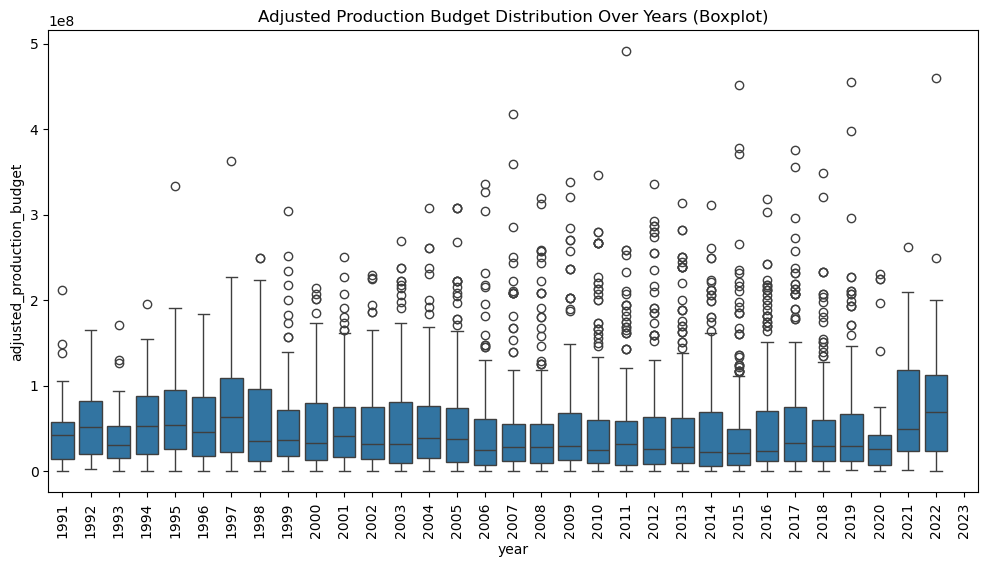

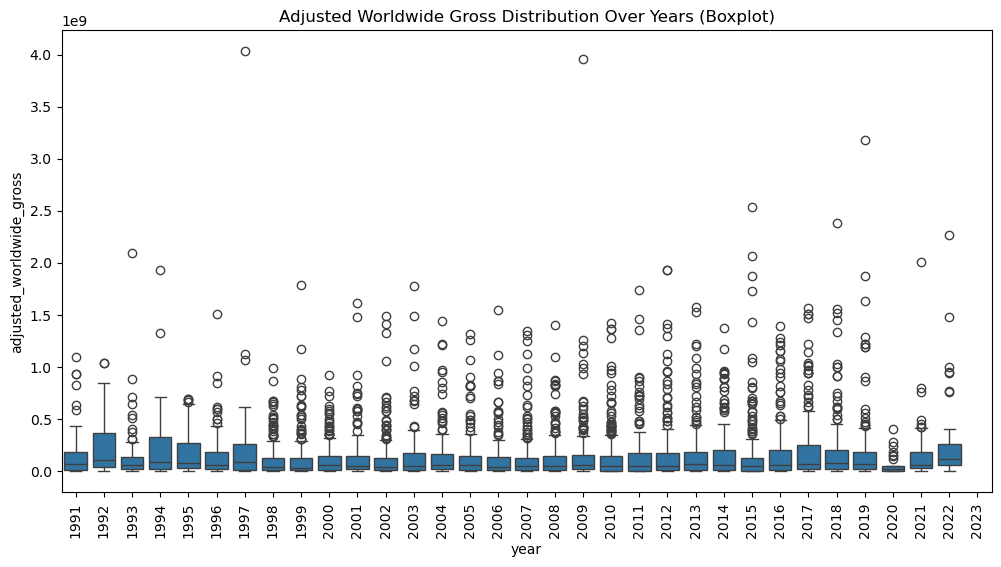

In [84]:
#Visualizing recent budget and gross earnings (since 1990)

filtered_data = money_data[money_data['year'] > 1990]

# Distribution by years with boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='adjusted_production_budget', data=filtered_data)
plt.xticks(rotation=90)  # X eksenindeki yılları net görmek için döndürme
plt.title('Adjusted Production Budget Distribution Over Years (Boxplot)')
plt.show()

# Likewise for Worldwide Gross
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='adjusted_worldwide_gross', data=filtered_data)
plt.xticks(rotation=90)
plt.title('Adjusted Worldwide Gross Distribution Over Years (Boxplot)')
plt.show()

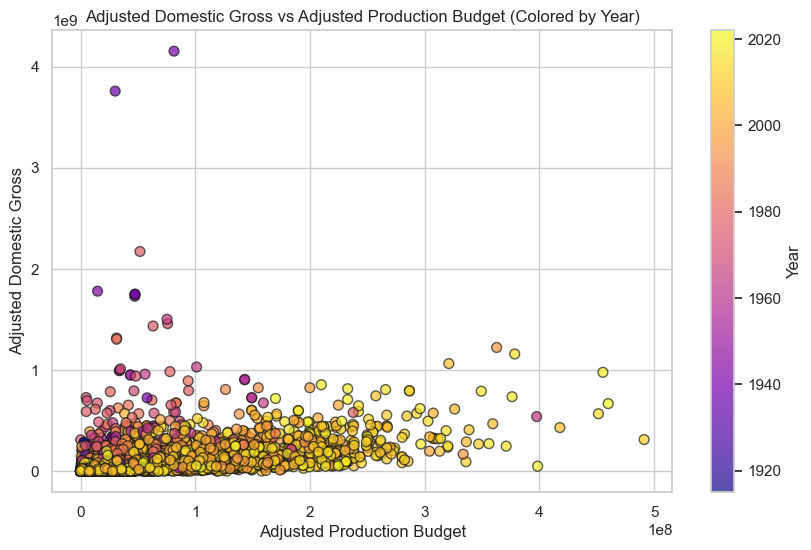

In [85]:
#Looking at adjusted budget vs gross with year encoded as color

# Set plot style
sns.set_theme(style="whitegrid")

# Scatter plot for Adjusted Domestic Gross vs Adjusted Production Budget
plt.figure(figsize=(10, 6))

# Define the scatter plot with better visual parameters
scatter = plt.scatter(money_data['adjusted_production_budget'],
                      money_data['adjusted_domestic_gross'],
                      c=money_data['year'], cmap='plasma', s=50, alpha=0.7, edgecolor='k')

# Add a color bar to indicate the years
cbar = plt.colorbar(scatter)
cbar.set_label('Year')

# Set titles and labels
plt.title('Adjusted Domestic Gross vs Adjusted Production Budget (Colored by Year)')
plt.xlabel('Adjusted Production Budget')
plt.ylabel('Adjusted Domestic Gross')

# Display the plot
plt.show()

These exploratory visualizations of the data emphasize the significant variance in gross earnings and, consequently, in return on investment (ROI). The color scale indicates that more recent films (yellow and light orange) tend to have higher production budgets than older films (purple), reflecting expansion and capitalization of the industry. 

Intercept: 7234130.906796038
Slope: 3.1917735698906093
R-squared: 0.2991609152718906


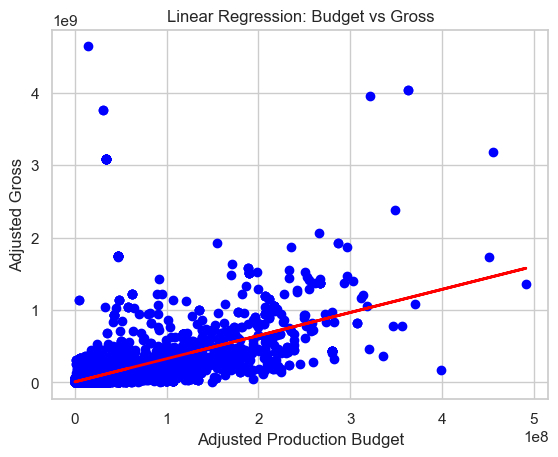

In [ ]:


# Select the independent (X) and dependent (y) variables
X = df_clean_movies['adjusted_production_budget'].dropna().values.reshape(-1, 1)
y = np.maximum(df_clean_movies['adjusted_worldwide_gross'], df_clean_movies['adjusted_domestic_gross']).dropna().values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)


# Print the coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")


# Predict values using the model
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

#Print r2
print(f"R-squared: {r2}")

# Plot the regression line and data points


plt.scatter(X, y, color='blue')
plt.plot(X, y_pred, color='red', linewidth=2)
plt.xlabel('Adjusted Production Budget')
plt.ylabel('Adjusted Gross')
plt.title('Linear Regression: Budget vs Gross')
plt.grid(True)
plt.show()

In [ ]:
budget_analysis

,budget_category,adjusted_ROI
0,Low Budget,3.626783
1,Medium Budget,3.359131
2,High Budget,2.026575


Given the noisy data, the first logical question is: "What is the relationship between budget and gross revenue?" From the model, we observe that for each budget dollar spent, there is an expected gross earning of $3.19, with budget explaining 30% of the variance. However, when analyzing budget categories, we notice that high-budget films have a diminished ROI compared to low-to-medium budget films. Therefore, increasing the budget within reasonable limits would be an effective strategy for maximizing revenue, but managing risk exposure is key - it's more worthwhile to be able to make 2 mid-budget films than to overreach for a higher budget film.

Approval Index: Intercept = -4.780234085446476, Coeff = 1.98174207797884, R-squared = 0.02581655240797187
Movie Average Rating: Intercept = -19.124910535811814, Coeff = 3.7141040599037485, R-squared = 0.04030578476911428


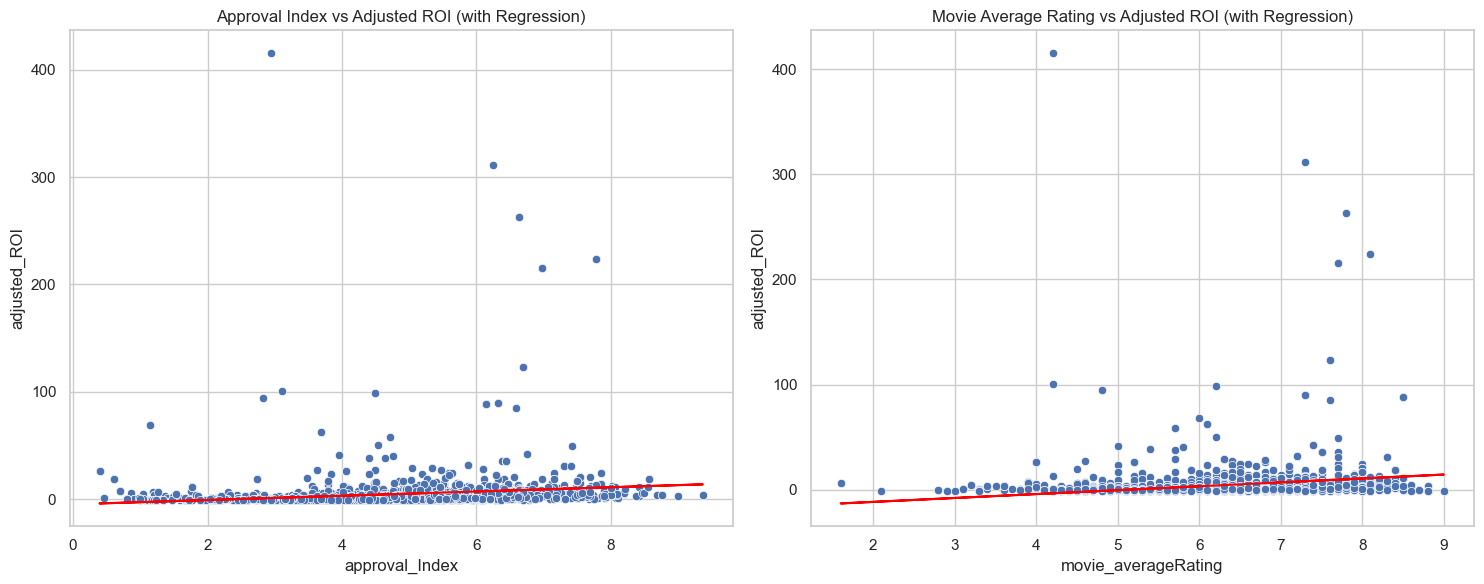

In [146]:

df_filtered = df_clean_movies[['approval_Index', 'adjusted_ROI']].dropna()
X_approval = df_filtered['approval_Index'].values.reshape(-1, 1)
y = df_filtered['adjusted_ROI'].values

model_approval = LinearRegression()
model_approval.fit(X_approval, y)
r2_approval = r2_score(y, model_approval.predict(X_approval))

df_filtered_rating = df_clean_movies[['movie_averageRating', 'adjusted_ROI']].dropna()
X_rating = df_filtered_rating['movie_averageRating'].values.reshape(-1, 1)
y = df_filtered_rating['adjusted_ROI'].values

model_rating = LinearRegression()
model_rating.fit(X_rating, y)

r2_rating = r2_score(y, model_rating.predict(X_rating))

print(f"Approval Index: Intercept = {model_approval.intercept_}, Coeff = {model_approval.coef_[0]}, R-squared = {r2_approval}")
print(f"Movie Average Rating: Intercept = {model_rating.intercept_}, Coeff = {model_rating.coef_[0]}, R-squared = {r2_rating}")

# Now, visualize the regression lines
plt.figure(figsize=(15,6))


plt.subplot(1, 2, 1)
sns.scatterplot(data=df_clean_movies, x='approval_Index', y='adjusted_ROI')
plt.plot(X_approval, model_approval.predict(X_approval), color='red', label='Regression Line')
plt.title('Approval Index vs Adjusted ROI (with Regression)')
plt.grid(True)


plt.subplot(1, 2, 2)
sns.scatterplot(data=df_clean_movies, x='movie_averageRating', y='adjusted_ROI')
plt.plot(X_rating, model_rating.predict(X_rating), color='red', label='Regression Line')
plt.title('Movie Average Rating vs Adjusted ROI (with Regression)')
plt.grid(True)

plt.tight_layout()
plt.show()

Both the approval index and movie average rating have very weak positive correlations with ROI, with R-squared values of 2.6% for Approval and 4% for Ratings. 
The relationships are small but present, as indicated by the positive slopes of both regression lines. However, the high dispersion of the data (especially in the ROI outliers) suggests other factors may have a stronger influence on ROI. In general it is recommended to ignore ratings as an avenue to ROI. 

In [89]:
# Run the ANOVA test on genre 
genre_anova_result = stats.f_oneway(*roi_data)

# Display the results
print(f'ANOVA F-statistic: {genre_anova_result.statistic}, p-value: {genre_anova_result.pvalue}')

ANOVA F-statistic: 5.5533461177646934, p-value: 9.504987699291441e-16



Interpretation:
Since the p-value is less than 0.05, we can reject the null hypothesis. This means that there are significant differences in the average ROI among the genres and some genres likely have better ROI compared to others.

A Tukey HSD test can help us with post-hoc analysis of these differences.

In [101]:
genre_tk_hsd = pairwise_tukeyhsd(df_cleaned_exploded['adjusted_ROI'], df_cleaned_exploded['genres_x'], alpha=.05)


c:\Users\erica\anaconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


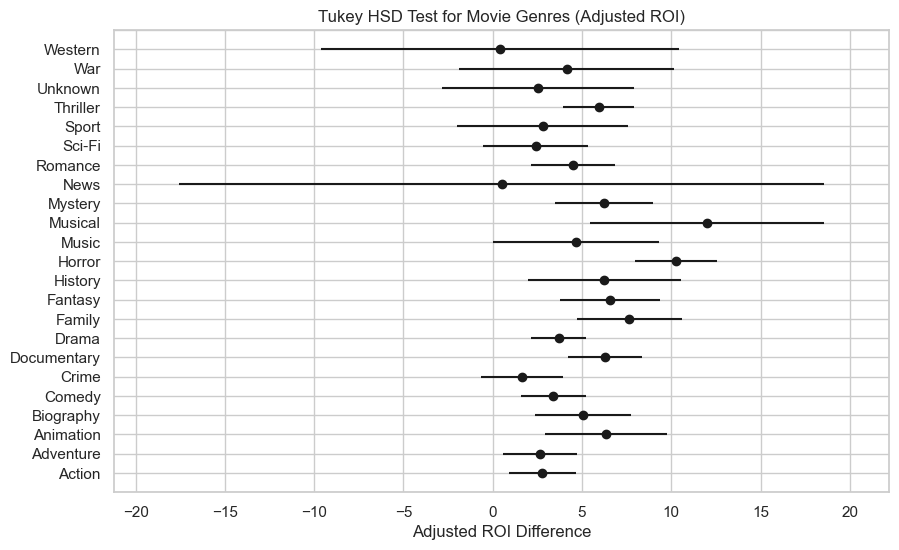

In [100]:

genre_tk_hsd.plot_simultaneous(figsize=(10,6))
plt.title('Tukey HSD Test for Movie Genres (Adjusted ROI)')
plt.xlabel('Adjusted ROI Difference')
plt.grid(True)
plt.show()

This visualization clearly shows the confidence intervals for ROI differences between various movie genres. It helps pinpoint which genres tend to perform better or worse in terms of ROI. For example, our data shows a high degree of confidence in the mean ROI for horror films. However, some high-performing genres, like musicals, are not as well-represented in the data, so they exhibit wider confidence intervals. Even so, musicals still rank among the genres with the strongest average ROIs and may still also be a good option. Drama represents a third tier with small confidence interval and strong mean ROI as another emminently reasonable choice depending on other production factors.

From the graph, we observe overall that each budget dollar generates an expected gross earning of $3.19, with budget explaining approximately 30% of the variance. However, when analyzing budget categories, we note a diminished ROI for high-budget films compared to low-to-medium budget films. Therefore, increasing the available budget within reasonable limits appears to be a more effective strategy.

In [97]:
# ANOVA test setup for count of principals in a movie
principal_count_roi = [df_clean_movies[df_clean_movies['principal_count'] == count]['adjusted_ROI'].dropna() for count in list(range(1,11))]

# Run the ANOVA test
pcr_anova_result = stats.f_oneway(*principal_count_roi)

# Display the results
print(f'ANOVA F-statistic: {pcr_anova_result.statistic}, p-value: {pcr_anova_result.pvalue}')

ANOVA F-statistic: 3.6479503890403273, p-value: 0.0001488357535619568


Results are significant for p<0.5 so we follow up with a tukey test to determine which numbers of principals perform well.

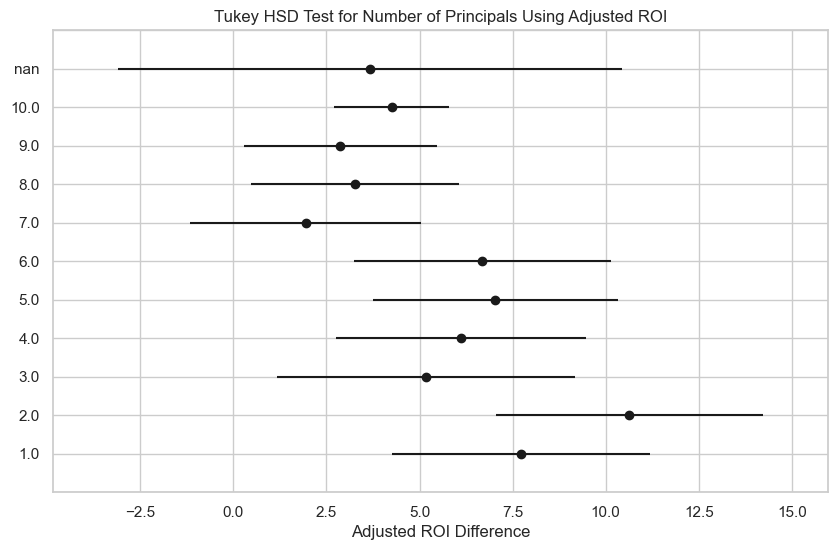

In [136]:
pcr_tk_hsd = pairwise_tukeyhsd(df_clean_movies['adjusted_ROI'], df_clean_movies['principal_count'], alpha=.05)

pcr_tk_hsd.plot_simultaneous(figsize=(10,6))
plt.title('Tukey HSD Test for Number of Principals Using Adjusted ROI')
plt.xlabel('Adjusted ROI Difference')
plt.grid(True)
plt.show()


This visualization helps identify which specific groups of principal counts perform better or worse in terms of ROI. The confidence intervals allow us to assess which principal counts significantly differ from each other in terms of financial performance. Specifically we see that 2 principals has signficiantly higher mean ROI than 7-10 principlas with 95% confidence, and has the highest mean ROI overall, so it seems likely that a "dynamic duo" can boost a film's appeal, while a large principal cast is more risky. 

In [ ]:
top_directors.head(25)

,director_name,adjusted_ROI,genres_x,adjusted_production_budget,budget_category,movie_count
0,Tod Williams,58.170677,Horror,4.004398e+06,Low Budget,1
1,Nitesh Tiwari,31.120996,"Action,Biography,Drama, Action",1.151181e+07,Medium Budget,2
2,Barry Jenkins,28.451563,"Drama, Drama,Romance, Horror",5.869757e+06,Medium Budget,3
3,William Lustig,27.571429,"Horror,Thriller, Action,Horror,Thriller",1.186512e+06,Low Budget,2
5,Jordan Peele,21.215722,"Drama, Horror,Mystery,Thriller, Comedy",1.856064e+07,Medium Budget,4
6,Stephen Daldry,20.850594,"Comedy,Drama,Music",8.406897e+06,Medium Budget,1
7,Jeff Wadlow,20.568114,"Action,Comedy,Crime, Comedy,Drama,Romance, Adv...",8.433343e+06,Medium Budget,8
8,John R. Leonetti,19.736494,"Horror,Mystery,Thriller, Drama,Fantasy,Horror",1.116972e+07,Medium Budget,2
9,Michael Madsen,18.735563,"Comedy,Drama,Romance, Thriller, Documentary,Dr...",6.184547e+06,Medium Budget,4
10,John Krasinski,18.698628,"Drama,Horror,Sci-Fi, Documentary",1.979644e+07,Medium Budget,2


Here we have a list of our top 25 available and affordable high-performing directors (measured by mean ROI) who work in Horror and/or Drama, with helpful annotations on budget category and the number of movies they directed that we have data for. Given the small sample sizes, statistical comparisons like ANOVA or Tukey's test may not provide significant insights. However, this list can serve as a reliable starting point for determining which directors to approach. With confidence in their track record, directors like Jordan Peele, Jeff Wadlow, or Michael Madsen would be ideal partners for any project. 

## Recommendations

### 1. Budget generously, but be aware that returns will diminish as the budget increases.
  
While increasing the budget can boost gross earnings, high-budget films tend to have a lower ROI compared to low-to-medium budget productions. Therefore, it’s important to strike a balance—allocate a sufficient budget to ensure quality, but avoid over-budgeting, as the returns may not justify the additional costs.

### 2. Don't chase ratings. 

Don't chase high ratings. Our analysis shows that movie ratings, such as approval indexes and average ratings, have a minimal impact on ROI. Instead of focusing solely on critical acclaim, it is more important to concentrate on optimizing production costs and targeting genres with a proven track record of profitability.

### 3. Stick to profitable genres.

Our analysis shows that certain genres, particularly Horror, Musicals, and Drama, consistently deliver higher ROI. By focusing on these top-performing genres, filmmakers can maximize returns at lower risk.

### 4. Dynamic duos hold broad appeal.

Stick to films with smaller principal casts. Larger principal casts generally do not show better ROI results, and dynamic duos tend to hold more broad appeal with audiences.

### 5. Work with known quality directors.

Collaborating with directors who have a proven track record in delivering successful films can significantly improve your chances of achieving a high ROI. Focus on directors who have consistently produced hits in key genres like Horror, Drama, and Musicals, especially within low-to-medium budget ranges. These directors are more likely to bring industry knowledge and experience that align with the film’s financial goals.
